In [1]:
!python --version

Python 3.10.12


In [2]:
# --- 0. INSTALL REQUIRED LIBRARIES ---


# --- 1. SETUP ---
print("Step 1: Setting up the environment...")
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
RANDOM_STATE = 42
SAMPLING_FRACTION = 0.2  # Adjust sample fraction for memory limit
TOP_N_FEATURES = 20

# --- PATH TO NSL-KDD DATA ---
NSL_KDD_PATH = '/kaggle/input/nslkdd' 
# --- HELPER FUNCTION FOR PLOTTING ---
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

# --- 2. NSL-KDD DATA LOADING & PREPARATION ---
def load_nsl_kdd(path, sample_frac=1.0):
    col_names = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
        'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
        'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
        'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
        'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
        'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
        'attack_label', 'difficulty'
    ]
    train_path = os.path.join(path, 'KDDTrain+.txt')
    test_path = os.path.join(path, 'KDDTest+.txt')
    if not os.path.exists(train_path) or not os.path.exists(test_path):
        raise FileNotFoundError(f"NSL-KDD files not found in directory: {path}")

    df_train = pd.read_csv(train_path, header=None, names=col_names)
    df_test = pd.read_csv(test_path, header=None, names=col_names)
    df = pd.concat([df_train, df_test], ignore_index=True)
    df = df.sample(frac=sample_frac, random_state=RANDOM_STATE)

    df.drop('difficulty', axis=1, inplace=True)

    # Create binary label: normal → Benign, else Attack
    df['binary_label'] = df['attack_label'].apply(lambda x: 'Benign' if x == 'normal' else 'Attack')

    # Map attack types to broader categories (analysis_category)
    df['analysis_category'] = df['attack_label'].replace({
        'normal': 'Benign', 'neptune': 'DoS', 'warezclient': 'R2L', 'ipsweep': 'Probe',
        'portsweep': 'Probe', 'teardrop': 'DoS', 'nmap': 'Probe', 'satan': 'Probe',
        'smurf': 'DoS', 'pod': 'DoS', 'back': 'DoS', 'guess_passwd': 'R2L', 'ftp_write': 'R2L',
        'multihop': 'R2L', 'rootkit': 'U2R', 'buffer_overflow': 'U2R', 'imap': 'R2L',
        'warezmaster': 'R2L', 'phf': 'R2L', 'land': 'DoS', 'loadmodule': 'U2R', 'perl': 'U2R'
    })

    # Convert categorical features using one-hot encoding except target columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in ['attack_label', 'binary_label', 'analysis_category']:
        if col in categorical_cols:
            categorical_cols.remove(col)
    df = pd.get_dummies(df, columns=categorical_cols, dummy_na=False)

    print(f"Data loaded and processed. Shape: {df.shape}")
    return df

# --- Load the data ---
print("Step 2: Loading and preparing NSL-KDD dataset...")
main_df = load_nsl_kdd(NSL_KDD_PATH, sample_frac=SAMPLING_FRACTION)

Step 1: Setting up the environment...


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Step 2: Loading and preparing NSL-KDD dataset...
Data loaded and processed. Shape: (29703, 122)


In [3]:
main_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
38166,0,44,115,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
122124,0,248,1273,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
137236,0,310,1957,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
59637,0,240,4664,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
117914,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False



Step 3: Visualizing class distribution...


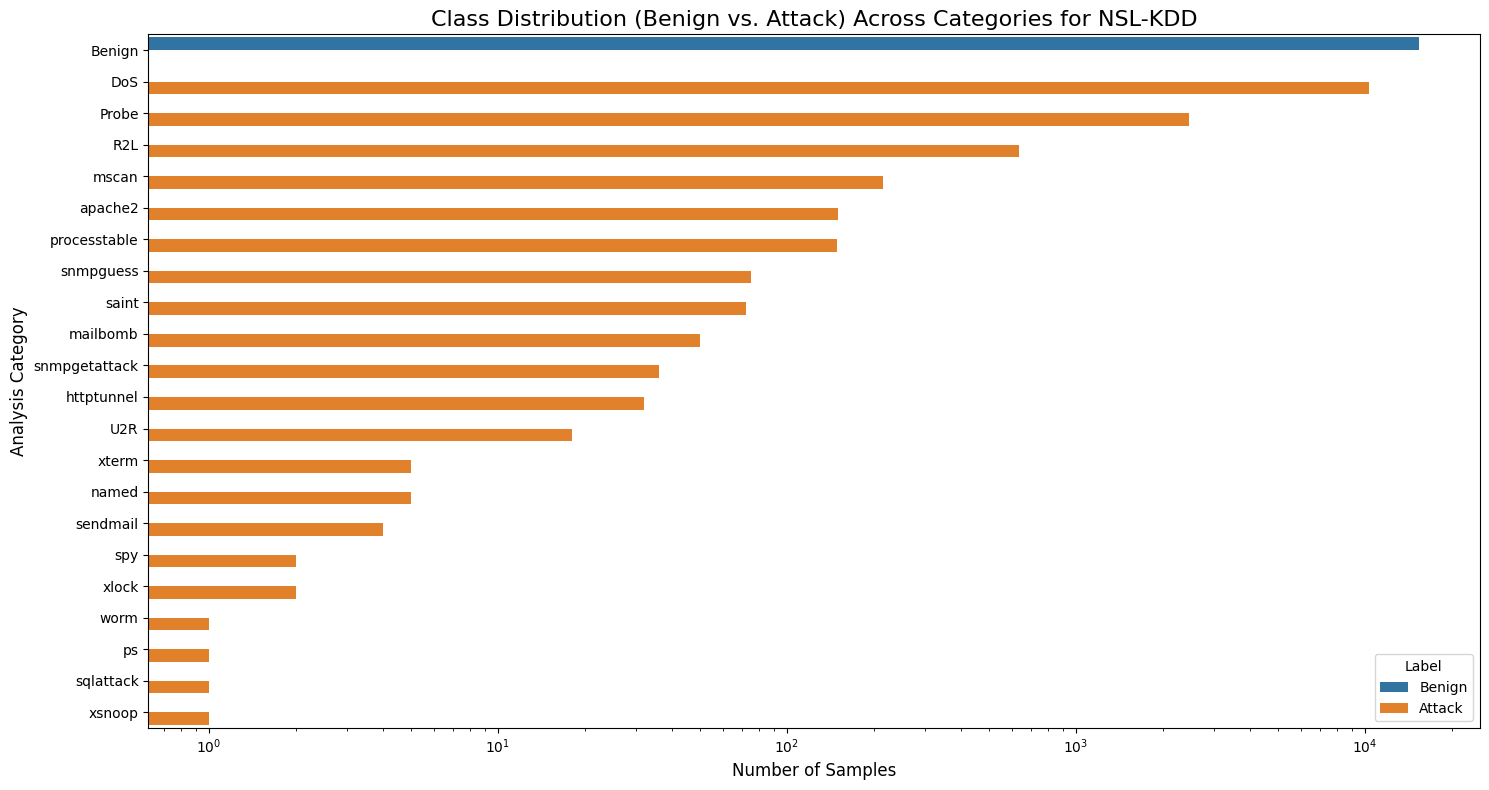

In [4]:
# --- 3. Visualize class distribution ---
print("\nStep 3: Visualizing class distribution...")
plt.figure(figsize=(15, 8))
sns.countplot(data=main_df, y='analysis_category', hue='binary_label',
              order=main_df['analysis_category'].value_counts().index)
plt.title('Class Distribution (Benign vs. Attack) Across Categories for NSL-KDD', fontsize=16)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Analysis Category', fontsize=12)
plt.xscale('log')  # log scale for imbalance
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [5]:
# --- 4. Core Analysis Loop ---
print("\nStep 4: Starting core analysis loop...")
all_results = {}
feature_importances_all_categories = {}

TARGET_CATEGORIES = main_df['analysis_category'].unique()
TARGET_CATEGORIES = [cat for cat in TARGET_CATEGORIES if cat != 'Benign']



Step 4: Starting core analysis loop...


In [6]:
TARGET_CATEGORIES

['DoS',
 'Probe',
 'apache2',
 'R2L',
 'mscan',
 'processtable',
 'httptunnel',
 'mailbomb',
 'saint',
 'snmpguess',
 'snmpgetattack',
 'xterm',
 'U2R',
 'worm',
 'named',
 'sendmail',
 'ps',
 'spy',
 'xlock',
 'sqlattack',
 'xsnoop']

In [7]:
main_df.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=122)

In [8]:
import pandas as pd

# Check column data types
print(main_df.dtypes)

# Count of each datatype
print("\nCount of each datatype:")
print(main_df.dtypes.value_counts())

# Separate lists of column names
numeric_cols = main_df.select_dtypes(include=['number']).columns.tolist()
object_cols = main_df.select_dtypes(include=['object']).columns.tolist()
float_cols  = main_df.select_dtypes(include=['float']).columns.tolist()
int_cols    = main_df.select_dtypes(include=['int']).columns.tolist()

print("\nNumeric columns:", len(numeric_cols), numeric_cols)
print("Object columns :", len(object_cols), object_cols)
print("Float columns  :", len(float_cols), float_cols)
print("Int columns    :", len(int_cols), int_cols)


duration          int64
src_bytes         int64
dst_bytes         int64
land              int64
wrong_fragment    int64
                  ...  
flag_S1            bool
flag_S2            bool
flag_S3            bool
flag_SF            bool
flag_SH            bool
Length: 122, dtype: object

Count of each datatype:
bool       81
int64      23
float64    15
object      3
Name: count, dtype: int64

Numeric columns: 38 ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host

In [9]:
import pandas as pd

# Make a copy to avoid modifying original
df = main_df.copy()

# Handle boolean columns (map True->1, False->0)
bool_cols = df.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df[col] = df[col].astype(int)

# Handle object (categorical) columns
obj_cols = df.select_dtypes(include=['object']).columns
for col in obj_cols:
    unique_vals = df[col].unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    df[col] = df[col].map(mapping)
    print(f"Column: {col}")
    print("Mapping:", mapping, "\n")

# Now df has updated columns
print(df.head())


Column: attack_label
Mapping: {'normal': 0, 'neptune': 1, 'satan': 2, 'apache2': 3, 'warezmaster': 4, 'teardrop': 5, 'ipsweep': 6, 'mscan': 7, 'back': 8, 'warezclient': 9, 'portsweep': 10, 'nmap': 11, 'smurf': 12, 'processtable': 13, 'guess_passwd': 14, 'httptunnel': 15, 'mailbomb': 16, 'saint': 17, 'snmpguess': 18, 'pod': 19, 'snmpgetattack': 20, 'xterm': 21, 'land': 22, 'loadmodule': 23, 'worm': 24, 'buffer_overflow': 25, 'named': 26, 'imap': 27, 'multihop': 28, 'sendmail': 29, 'ps': 30, 'spy': 31, 'xlock': 32, 'perl': 33, 'rootkit': 34, 'sqlattack': 35, 'xsnoop': 36} 

Column: binary_label
Mapping: {'Benign': 0, 'Attack': 1} 

Column: analysis_category
Mapping: {'Benign': 0, 'DoS': 1, 'Probe': 2, 'apache2': 3, 'R2L': 4, 'mscan': 5, 'processtable': 6, 'httptunnel': 7, 'mailbomb': 8, 'saint': 9, 'snmpguess': 10, 'snmpgetattack': 11, 'xterm': 12, 'U2R': 13, 'worm': 14, 'named': 15, 'sendmail': 16, 'ps': 17, 'spy': 18, 'xlock': 19, 'sqlattack': 20, 'xsnoop': 21} 

        duration  src_

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29703 entries, 38166 to 137223
Columns: 122 entries, duration to flag_SH
dtypes: float64(15), int64(107)
memory usage: 27.9 MB


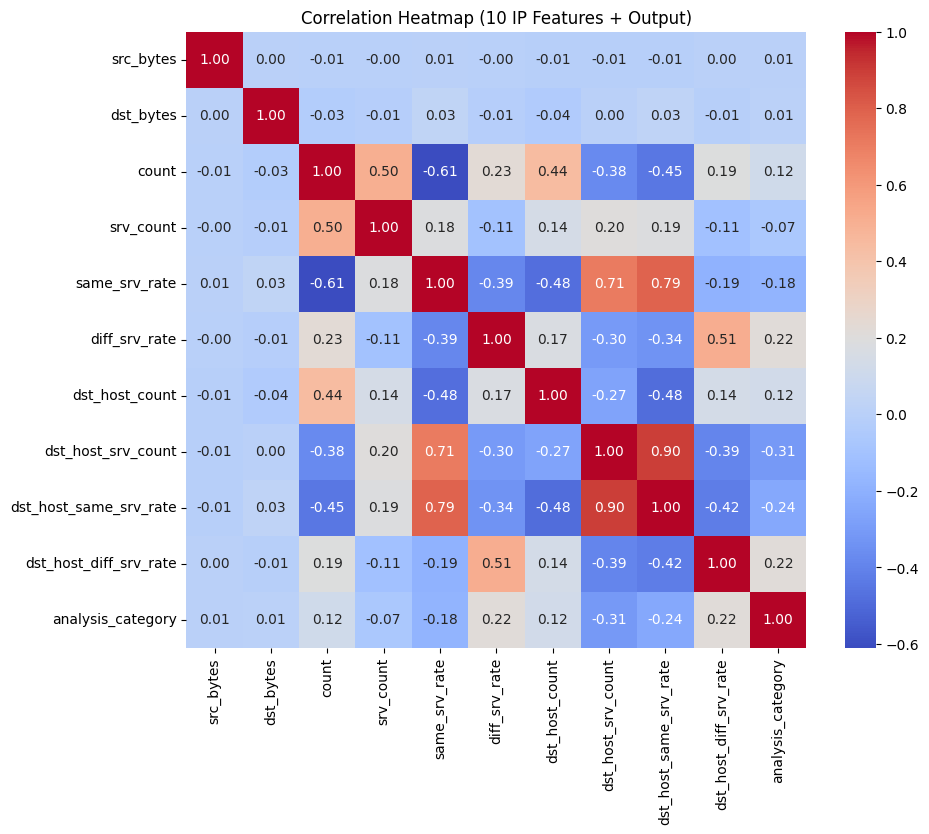

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: pick 10 IP features (replace with your actual feature names)
ip_features = ["src_bytes", "dst_bytes", "count", "srv_count", 
               "same_srv_rate", "diff_srv_rate", "dst_host_count", 
               "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate"]

# Keep only chosen features + output column
corr_df = df[ip_features + ["analysis_category"]].copy()

# Encode categorical target to numeric for correlation
corr_df["analysis_category"] = corr_df["analysis_category"].astype("category").cat.codes

# Compute correlation
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (10 IP Features + Output)")
plt.show()


Row counts per label in analysis_category:

analysis_category
Benign           15449
DoS              10338
Probe             2462
R2L                635
mscan              215
apache2            150
processtable       149
snmpguess           75
saint               72
mailbomb            50
snmpgetattack       36
httptunnel          32
U2R                 18
xterm                5
named                5
sendmail             4
spy                  2
xlock                2
worm                 1
ps                   1
sqlattack            1
xsnoop               1
Name: count, dtype: int64


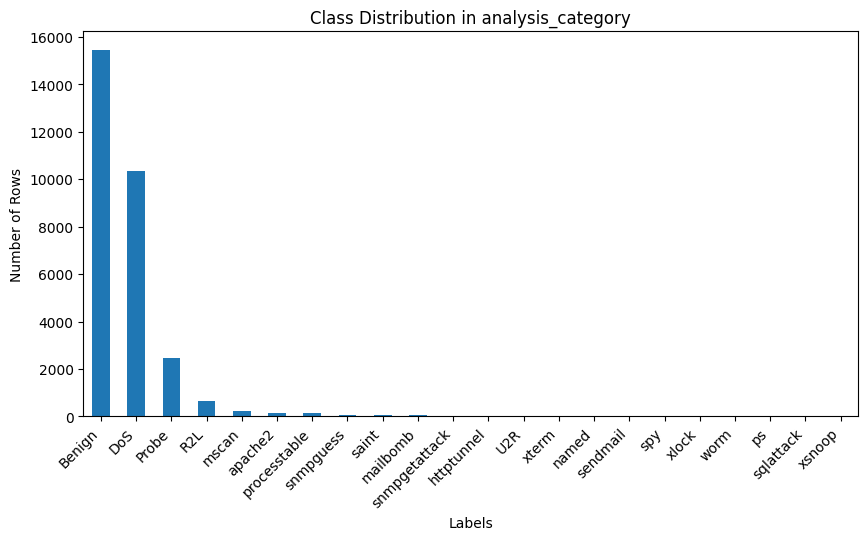

In [12]:
import matplotlib.pyplot as plt

# Count unique values
label_counts = main_df["analysis_category"].value_counts()

# Print counts
print("Row counts per label in analysis_category:\n")
print(label_counts)

# Plot barplot
plt.figure(figsize=(10,5))
label_counts.plot(kind="bar")
plt.title("Class Distribution in analysis_category")
plt.xlabel("Labels")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45, ha='right')
plt.show()


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.utils import resample

# Copy original
df = main_df.copy()

# Step 1: Drop very rare labels (<= 36 rows as listed)
rare_labels = ["snmpgetattack", "httptunnel", "U2R", "xterm", "named",
               "sendmail", "spy", "xlock", "worm", "ps", "sqlattack", "xsnoop"]

df = df[~df["analysis_category"].isin(rare_labels)]

print("✅ Remaining class distribution:")
print(df["analysis_category"].value_counts())

# Step 2: Define X and y
X = df.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y = df["analysis_category"]

# Step 3: Manual oversampling (instead of SMOTE)
df_balanced = pd.concat([
    resample(group, replace=True, n_samples=df["analysis_category"].value_counts().max(), random_state=42)
    for _, group in df.groupby("analysis_category")
])

# Shuffle rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



✅ Remaining class distribution:
analysis_category
Benign          15449
DoS             10338
Probe            2462
R2L               635
mscan             215
apache2           150
processtable      149
snmpguess          75
saint              72
mailbomb           50
Name: count, dtype: int64


✅ Top 30 features selected by RFE:
1. duration
2. src_bytes
3. dst_bytes
4. hot
5. logged_in
6. count
7. srv_count
8. serror_rate
9. srv_serror_rate
10. rerror_rate
11. same_srv_rate
12. diff_srv_rate
13. dst_host_count
14. dst_host_srv_count
15. dst_host_same_srv_rate
16. dst_host_diff_srv_rate
17. dst_host_same_src_port_rate
18. dst_host_srv_diff_host_rate
19. dst_host_serror_rate
20. dst_host_srv_serror_rate
21. dst_host_rerror_rate
22. dst_host_srv_rerror_rate
23. protocol_type_icmp
24. protocol_type_tcp
25. service_eco_i
26. service_ecr_i
27. service_http
28. service_private
29. flag_S0
30. flag_SF


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


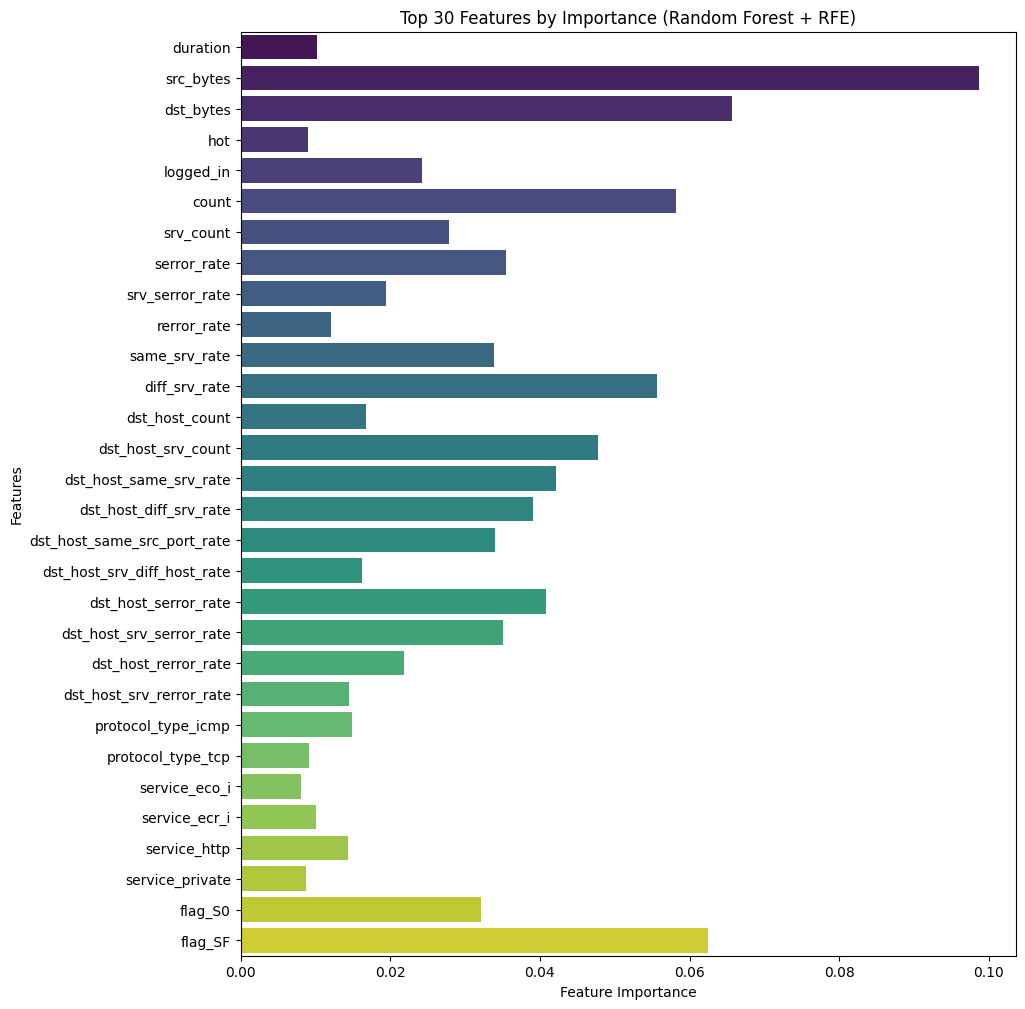

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# Copy df and separate target
X = df.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y = df["analysis_category"]

# Encode target to numeric
y_encoded = y.astype("category").cat.codes

# Step 1: Initialize Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_encoded)  # Fit to get feature importances

# Step 2: Initialize RFE to select top 30 features
rfe = RFE(estimator=rf, n_features_to_select=30, step=1)
rfe.fit(X, y_encoded)

# Step 3: Get top features
top_features = X.columns[rfe.support_].tolist()
top_importances = rf.feature_importances_[rfe.support_]

print("✅ Top 30 features selected by RFE:")
for idx, feat in enumerate(top_features, 1):
    print(f"{idx}. {feat}")

# Step 4: Plot horizontal bar chart
plt.figure(figsize=(10,12))
sns.barplot(x=top_importances, y=top_features, palette="viridis")
plt.title("Top 30 Features by Importance (Random Forest + RFE)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()


✅ Top features selected by Lasso:
dst_host_same_srv_rate         0.386409
service_telnet                 0.222828
diff_srv_rate                  0.191353
service_pop_3                  0.176715
flag_RSTR                      0.157849
dst_host_rerror_rate           0.155557
flag_S3                        0.137437
is_guest_login                 0.114372
dst_host_srv_serror_rate       0.103709
srv_diff_host_rate             0.095578
dst_host_diff_srv_rate         0.094027
service_imap4                  0.093066
dst_host_count                 0.088895
service_eco_i                  0.076756
service_sunrpc                 0.041036
service_private                0.038216
same_srv_rate                  0.032233
service_pm_dump                0.027376
flag_SH                        0.025089
flag_RSTO                      0.009395
flag_RSTOS0                    0.006142
num_failed_logins              0.001405
service_urh_i                 -0.000631
service_time                  -0.000925
servic

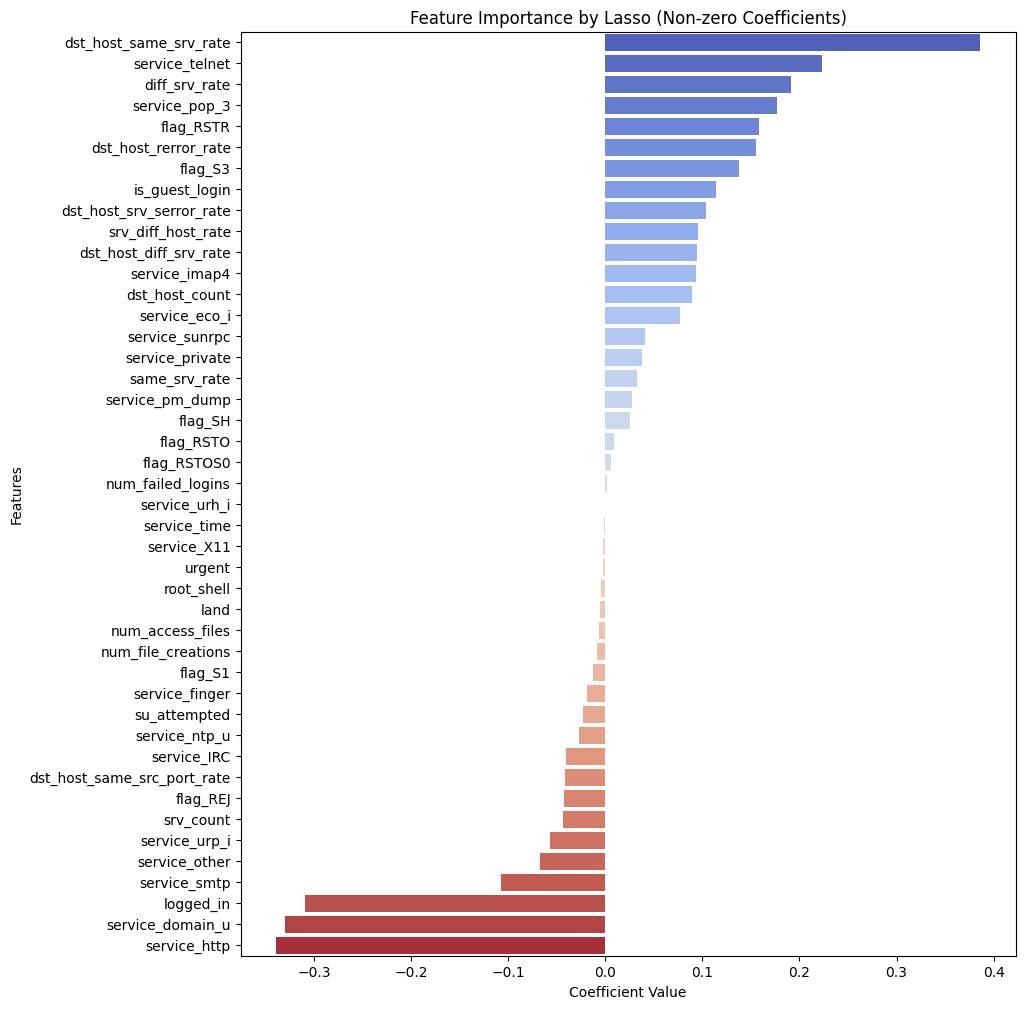

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns

# Copy df and separate target
X = df.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y = df["analysis_category"]

# Encode target to numeric
y_encoded = y.astype("category").cat.codes

# Step 1: Standardize features (important for Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Fit Lasso
lasso = Lasso(alpha=0.01, random_state=42)  # alpha controls regularization strength
lasso.fit(X_scaled, y_encoded)

# Step 3: Get feature coefficients
feature_coef = pd.Series(lasso.coef_, index=X.columns)

# Step 4: Select top features (non-zero coefficients)
top_features = feature_coef[feature_coef != 0].sort_values(ascending=False)
print("✅ Top features selected by Lasso:")
print(top_features)

# Step 5: Plot horizontal bar chart
plt.figure(figsize=(10,12))
sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")
plt.title("Feature Importance by Lasso (Non-zero Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


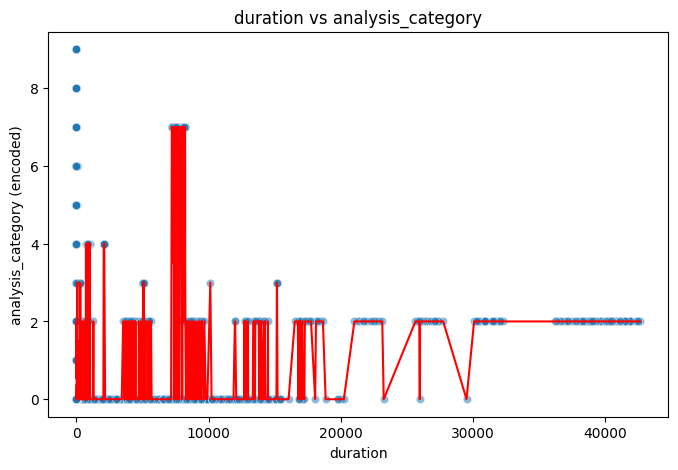

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


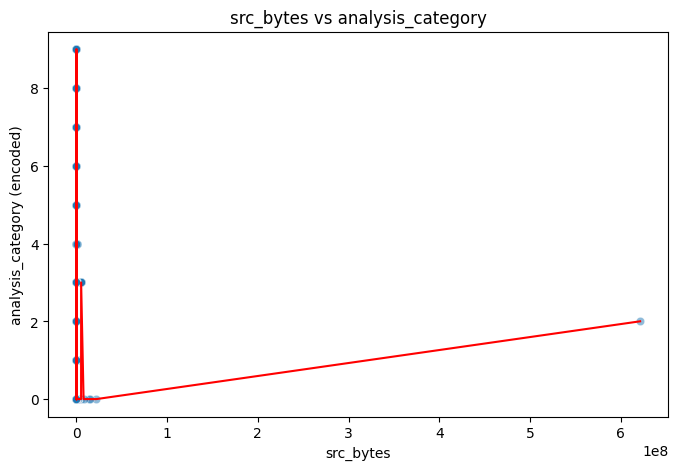

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


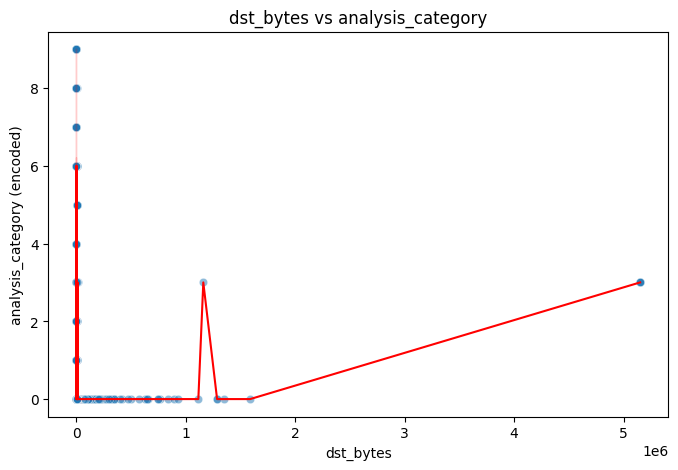

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


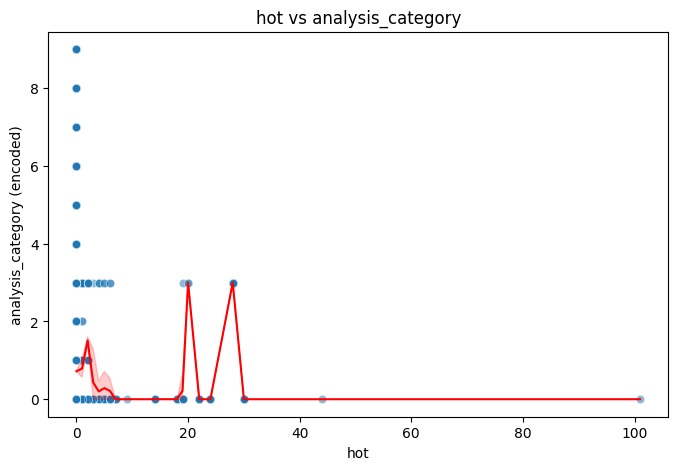

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


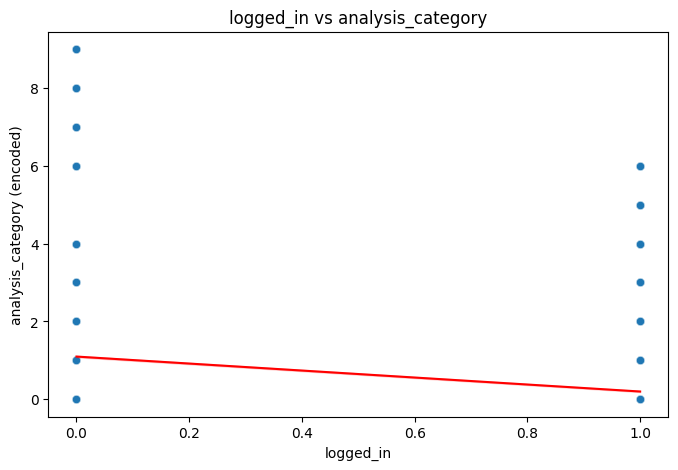

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


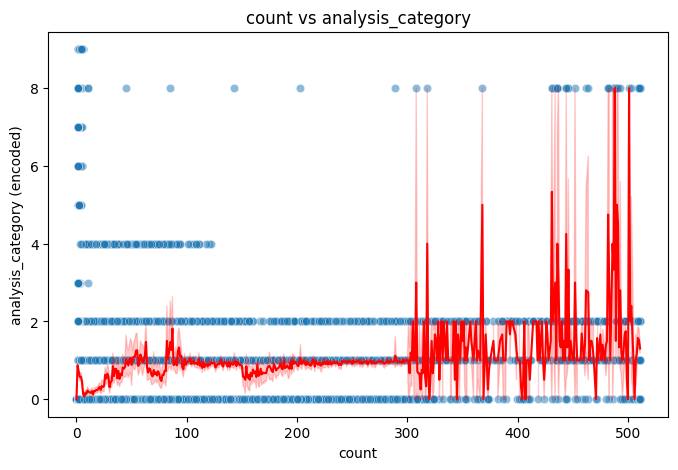

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


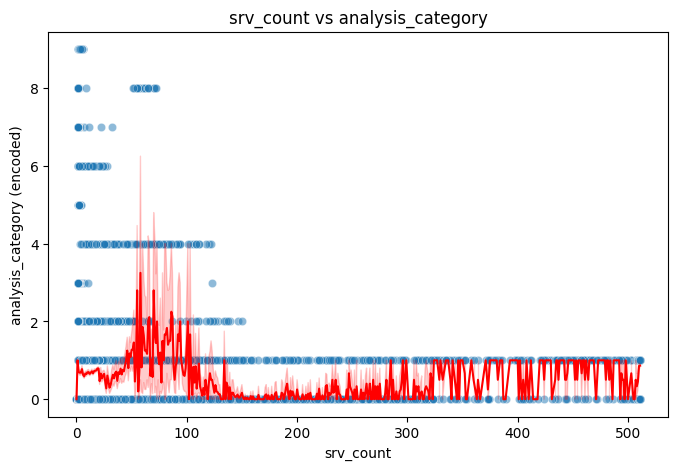

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


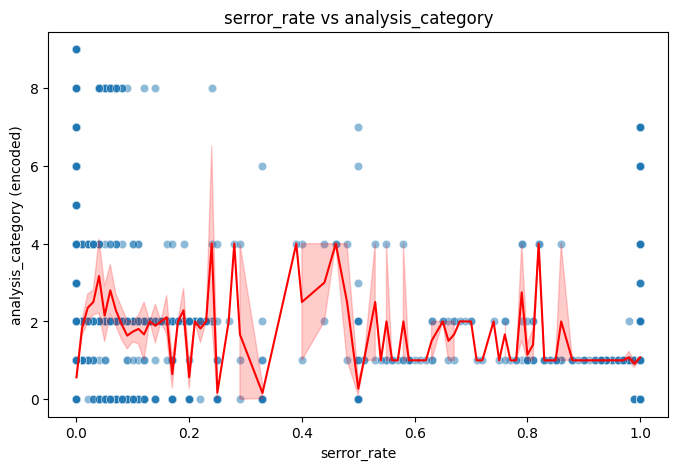

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


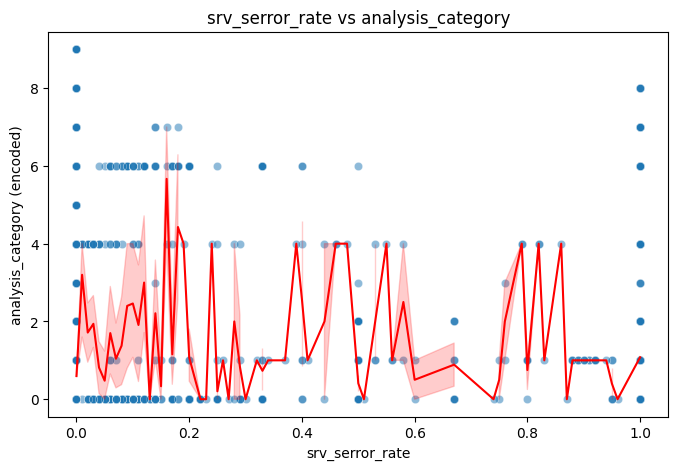

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


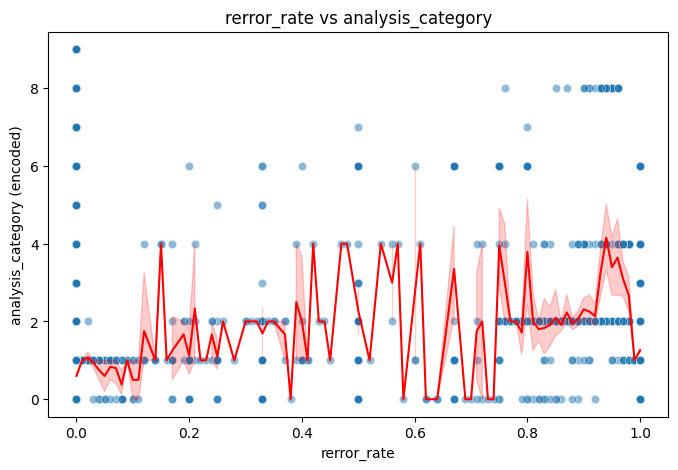

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


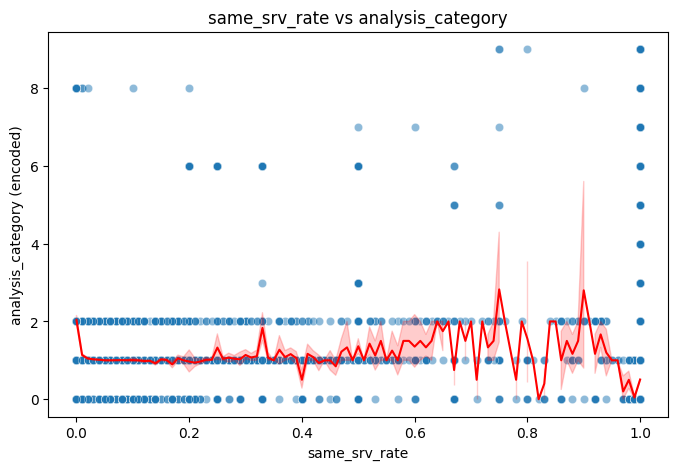

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


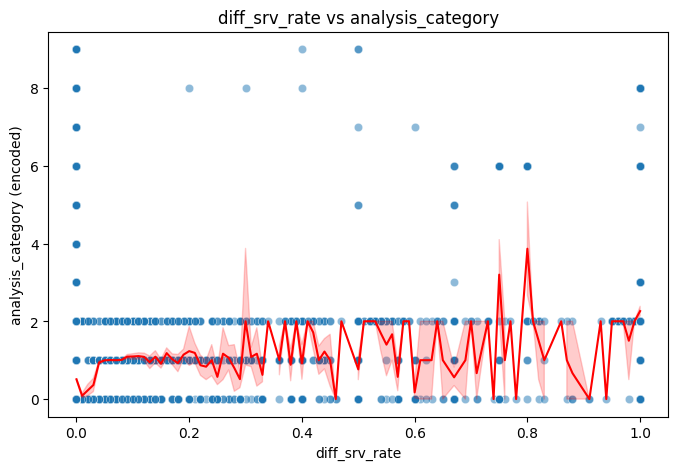

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


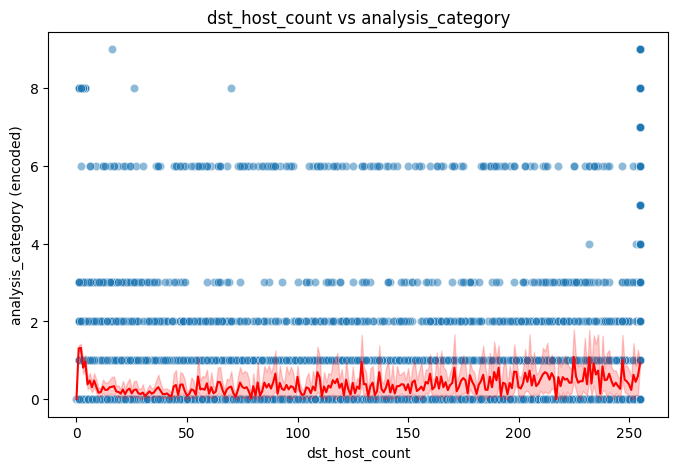

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


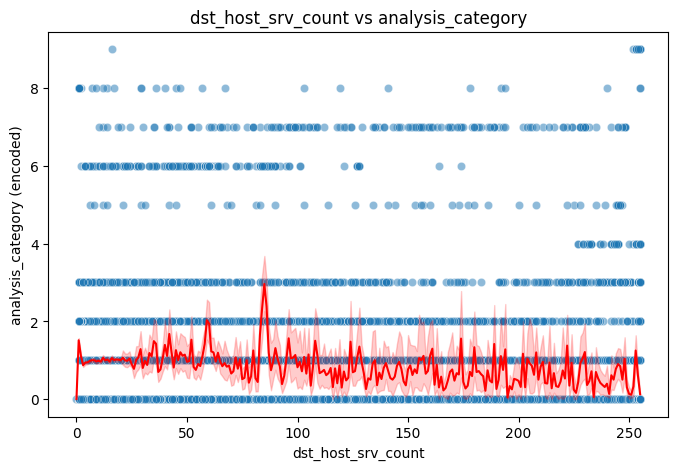

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


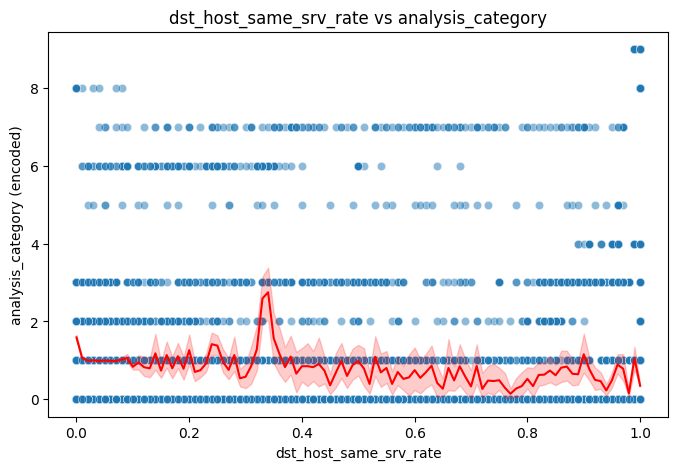

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


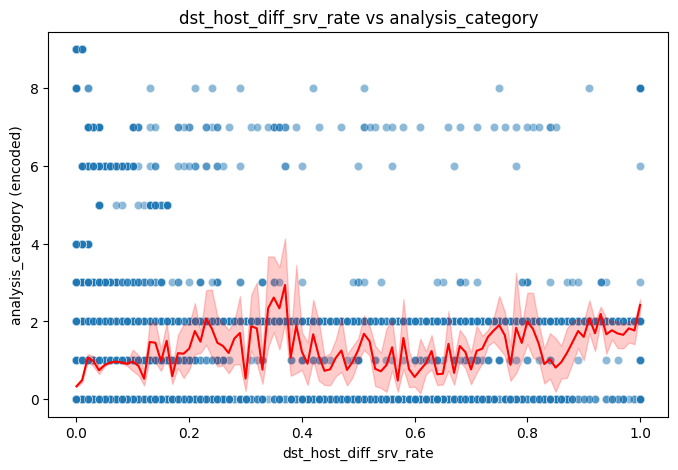

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


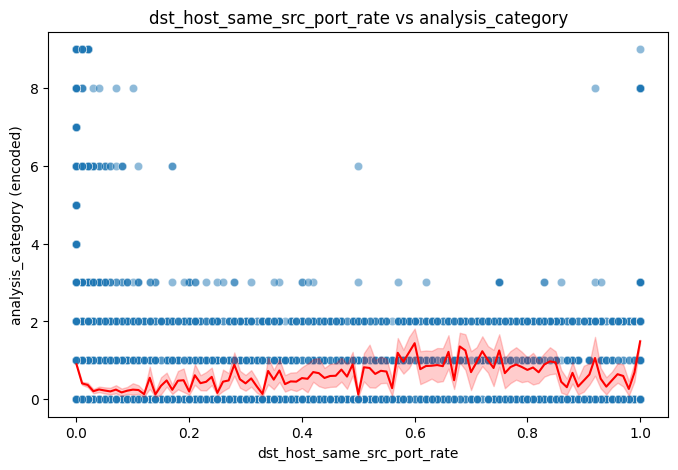

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


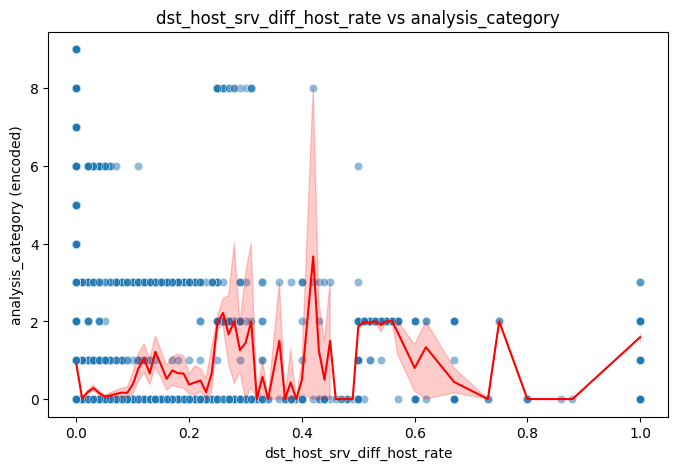

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


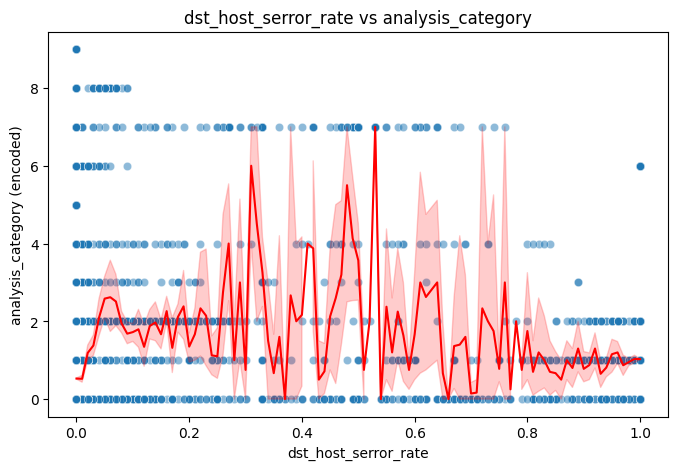

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


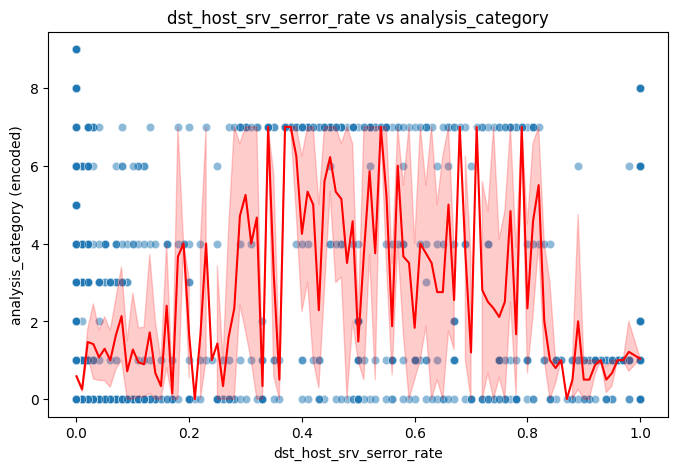

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


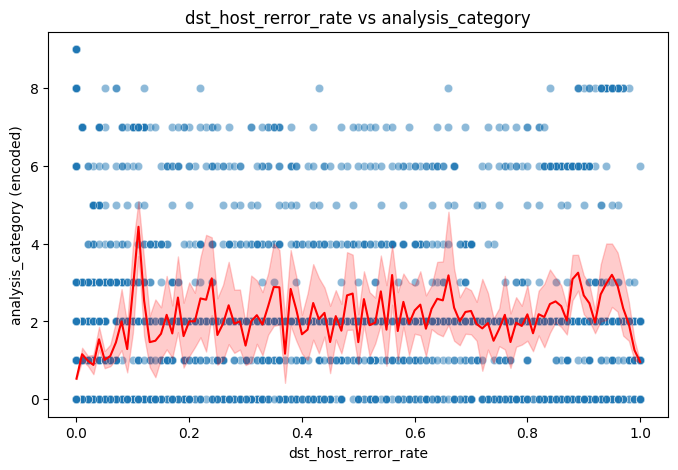

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


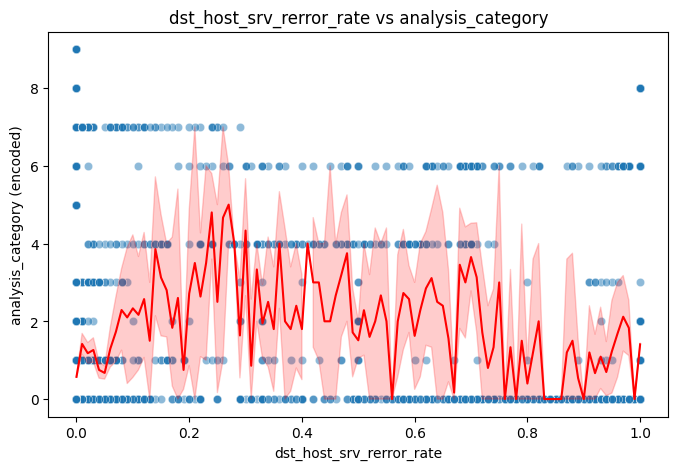

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


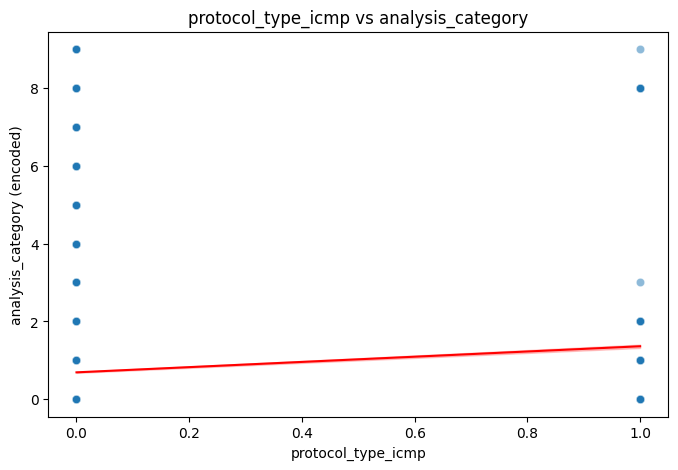

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


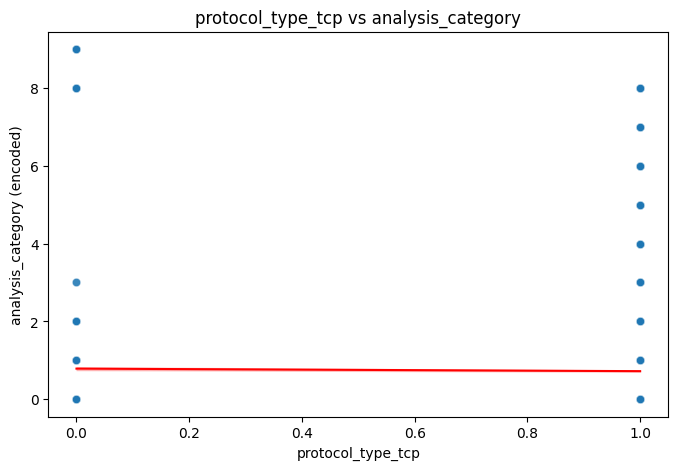

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


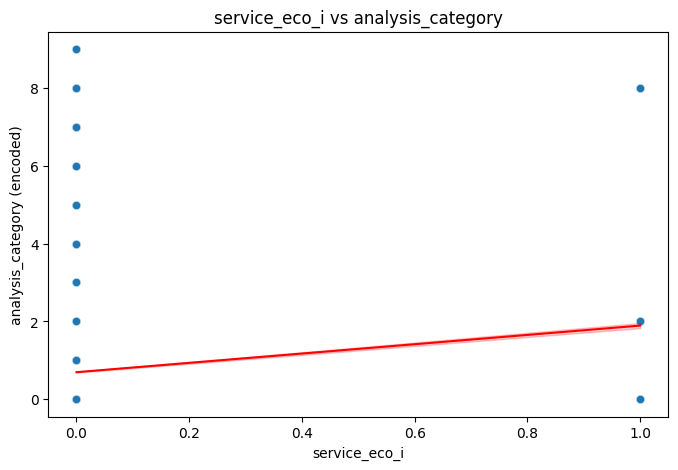

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


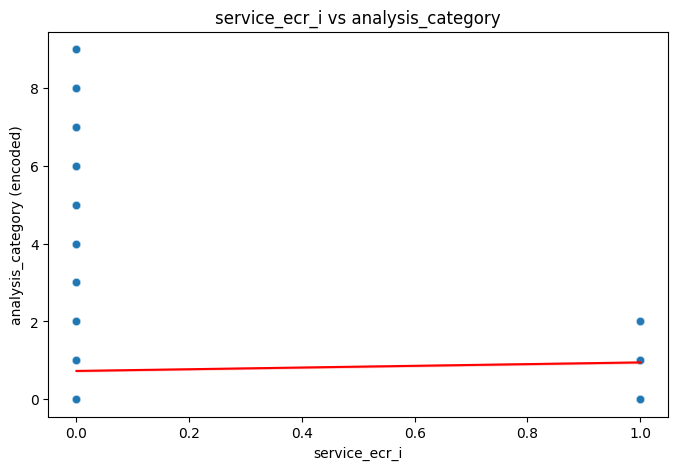

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


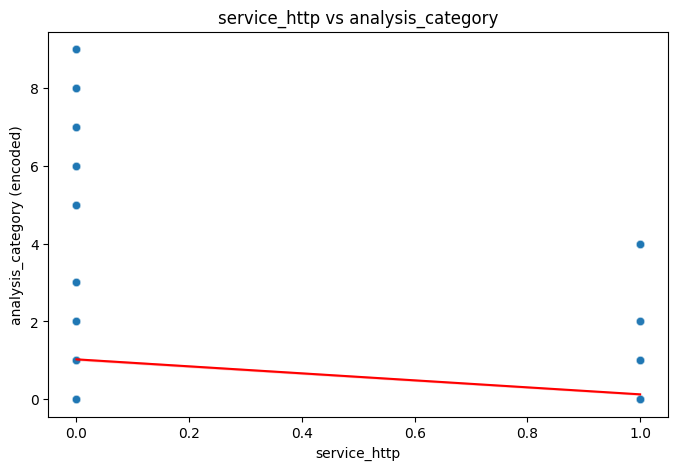

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


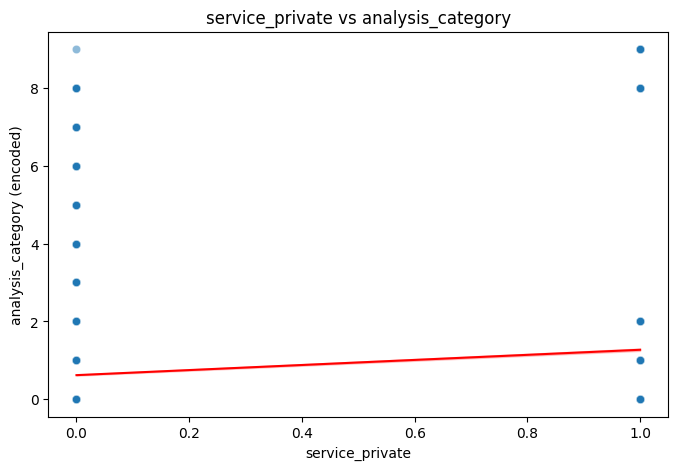

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


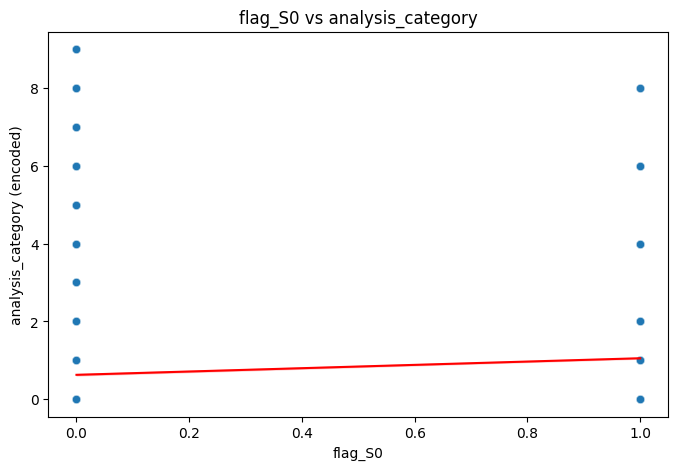

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


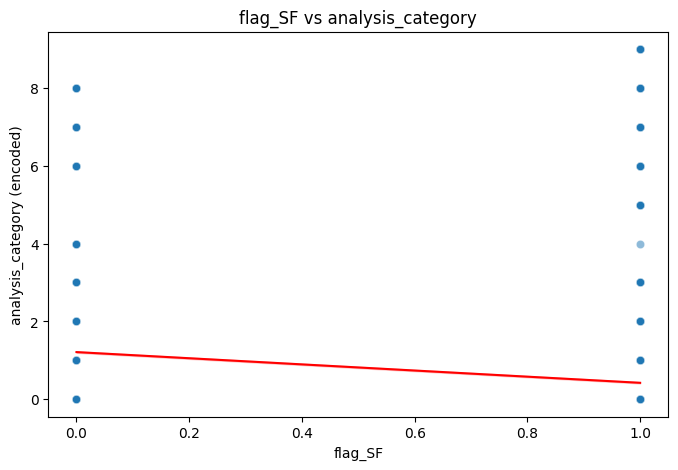

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of 30 features
features = [
    "duration", "src_bytes", "dst_bytes", "hot", "logged_in", "count", "srv_count",
    "serror_rate", "srv_serror_rate", "rerror_rate", "same_srv_rate", "diff_srv_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "protocol_type_icmp", "protocol_type_tcp", "service_eco_i", "service_ecr_i",
    "service_http", "service_private", "flag_S0", "flag_SF"
]

# Make a copy of df
plot_df = df[features + ["analysis_category"]].copy()

# Encode categorical target to numeric
plot_df["analysis_category_num"] = plot_df["analysis_category"].astype("category").cat.codes

# Plot each feature vs output
for feat in features:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=feat, y="analysis_category_num", data=plot_df, alpha=0.5)
    sns.lineplot(
        x=feat, y="analysis_category_num", data=plot_df.sort_values(feat),
        color='red'
    )
    plt.title(f"{feat} vs analysis_category")
    plt.ylabel("analysis_category (encoded)")
    plt.xlabel(feat)
    plt.show()


In [17]:
print(df_balanced.head())



X_res = df_balanced.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y_res = df_balanced["analysis_category"]

print("\n✅ After oversampling (manual resample):")
print(y_res.value_counts())

# Step 4: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Step 5: Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 6: Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Step 7: Evaluation
acc = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("\n🎯 Random Forest Results")
print("Accuracy:", acc)
print("Log Loss:", loss)
print("\nClassification Report:\n", report)


   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0          0         44     0               0       0    0   
1         0          0          0     0               0       0    0   
2       280     283618          0     0               0       0    0   
3         0          0         15     0               0       0    0   
4         0        260          0     0               0       0    2   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                  0          0                0  ...     False      False   
1                  0          0                0  ...     False      False   
2                  0          0                0  ...     False      False   
3                  0          0                0  ...     False       True   
4                  0          1                0  ...     False      False   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0        False      Fals

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report

# Step 3: Separate features and target
X_res = df_balanced.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y_res = df_balanced["analysis_category"]

print("\n✅ After oversampling (manual resample):")
print(y_res.value_counts())

# Step 4: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Step 5: Train Decision Tree
clf = DecisionTreeClassifier(random_state=42, max_depth=None, criterion='gini')
clf.fit(X_train, y_train)

# Step 6: Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Step 7: Evaluation
acc = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("\n🎯 Decision Tree Results")
print("Accuracy:", acc)
print("Log Loss:", loss)
print("\nClassification Report:\n", report)



✅ After oversampling (manual resample):
analysis_category
processtable    15449
DoS             15449
R2L             15449
mscan           15449
Benign          15449
snmpguess       15449
saint           15449
apache2         15449
mailbomb        15449
Probe           15449
Name: count, dtype: int64

🎯 Decision Tree Results
Accuracy: 0.9995468962392388
Log Loss: 0.016331514902184662

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      3090
         DoS       1.00      1.00      1.00      3089
       Probe       1.00      1.00      1.00      3090
         R2L       1.00      1.00      1.00      3090
     apache2       1.00      1.00      1.00      3090
    mailbomb       1.00      1.00      1.00      3090
       mscan       1.00      1.00      1.00      3090
processtable       1.00      1.00      1.00      3090
       saint       1.00      1.00      1.00      3089
   snmpguess       1.00      1.00      1.00 

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Step 3: Separate features and target
X_res = df_balanced.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y_res = df_balanced["analysis_category"]

print("\n✅ After oversampling (manual resample):")
print(y_res.value_counts())

# ✅ Encode target labels to numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(y_res)

# Step 4: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 5: Train XGBoost Classifier
clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',   # For multiclass classification
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)
clf.fit(X_train, y_train)

# Step 6: Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Step 7: Evaluation
acc = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)
report = classification_report(
    le.inverse_transform(y_test),  # Convert back to original labels
    le.inverse_transform(y_pred)
)

print("\n🎯 XGBoost Results")
print("Accuracy:", acc)
print("Log Loss:", loss)
print("\nClassification Report:\n", report)



✅ After oversampling (manual resample):
analysis_category
processtable    15449
DoS             15449
R2L             15449
mscan           15449
Benign          15449
snmpguess       15449
saint           15449
apache2         15449
mailbomb        15449
Probe           15449
Name: count, dtype: int64

🎯 XGBoost Results
Accuracy: 0.9996763544565991
Log Loss: 0.0012488951573990318

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      3090
         DoS       1.00      1.00      1.00      3089
       Probe       1.00      1.00      1.00      3090
         R2L       1.00      1.00      1.00      3090
     apache2       1.00      1.00      1.00      3090
    mailbomb       1.00      1.00      1.00      3090
       mscan       1.00      1.00      1.00      3090
processtable       1.00      1.00      1.00      3090
       saint       1.00      1.00      1.00      3089
   snmpguess       1.00      1.00      1.00      

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Step 1: Separate features and target
X_res = df_balanced.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y_res = df_balanced["analysis_category"]

# Step 2: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_res)

# Step 3: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 4: Initialize individual classifiers
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=None, random_state=42)
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

# Step 5: Voting classifier (soft voting for probabilities)
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('dt', dt_clf), ('xgb', xgb_clf)],
    voting='soft'  # soft = uses predicted probabilities
)

# Step 6: Train the voting classifier
voting_clf.fit(X_train, y_train)

# Step 7: Predictions
y_pred = voting_clf.predict(X_test)
y_pred_proba = voting_clf.predict_proba(X_test)

# Step 8: Evaluation
acc = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)
report = classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred)
)

print("\n🎯 Voting Hybrid Results")
print("Accuracy:", acc)
print("Log Loss:", loss)
print("\nClassification Report:\n", report)



🎯 Voting Hybrid Results
Accuracy: 0.9997087190109393
Log Loss: 0.001236052207682551

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      3090
         DoS       1.00      1.00      1.00      3089
       Probe       1.00      1.00      1.00      3090
         R2L       1.00      1.00      1.00      3090
     apache2       1.00      1.00      1.00      3090
    mailbomb       1.00      1.00      1.00      3090
       mscan       1.00      1.00      1.00      3090
processtable       1.00      1.00      1.00      3090
       saint       1.00      1.00      1.00      3089
   snmpguess       1.00      1.00      1.00      3090

    accuracy                           1.00     30898
   macro avg       1.00      1.00      1.00     30898
weighted avg       1.00      1.00      1.00     30898



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Step 1: Separate features and target
X_res = df_balanced.drop(["attack_label", "binary_label", "analysis_category"], axis=1)
y_res = df_balanced["analysis_category"]

# Step 2: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_res)

# Step 3: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 4: Define base learners
base_learners = [
    ('dt', DecisionTreeClassifier(max_depth=None, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)),
    ('xgb', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        use_label_encoder=False
    ))
]

# Step 5: Define meta-learner
meta_learner = LogisticRegression(max_iter=1000, multi_class='multinomial')

# Step 6: Build Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    stack_method='predict_proba',  # use probabilities for stacking
    cv=5,  # cross-validation for meta-learner training
    n_jobs=-1
)

# Step 7: Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Step 8: Predictions
y_pred = stacking_clf.predict(X_test)
y_pred_proba = stacking_clf.predict_proba(X_test)

# Step 9: Evaluation
acc = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_pred_proba)
report = classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred)
)

print("\n🎯 Stacking Hybrid Results")
print("Accuracy:", acc)
print("Log Loss:", loss)
print("\nClassification Report:\n", report)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



🎯 Stacking Hybrid Results
Accuracy: 0.9997734481196194
Log Loss: 0.0013852707296343554

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      3090
         DoS       1.00      1.00      1.00      3089
       Probe       1.00      1.00      1.00      3090
         R2L       1.00      1.00      1.00      3090
     apache2       1.00      1.00      1.00      3090
    mailbomb       1.00      1.00      1.00      3090
       mscan       1.00      1.00      1.00      3090
processtable       1.00      1.00      1.00      3090
       saint       1.00      1.00      1.00      3089
   snmpguess       1.00      1.00      1.00      3090

    accuracy                           1.00     30898
   macro avg       1.00      1.00      1.00     30898
weighted avg       1.00      1.00      1.00     30898



In [23]:
len(df_balanced.columns)

122

In [25]:
import pickle
# ------------------ SAVE MODEL ------------------ #
with open("stacking_model.pkl", "wb") as file:
    pickle.dump({
        "model": stacking_clf,
        "label_encoder": le,
        "feature_columns": X_res.columns.tolist()
    }, file)

print("\n✅ Model saved as 'stacking_model.pkl'")

# ------------------ LOAD MODEL ------------------ #
with open("stacking_model.pkl", "rb") as file:
    saved_data = pickle.load(file)

loaded_model = saved_data["model"]
loaded_le = saved_data["label_encoder"]
feature_columns = saved_data["feature_columns"]

print("\n✅ Model loaded successfully!")

# ------------------ PREDICT SAMPLE INPUT ------------------ #
# Example: Replace with your own feature values (must be length = 122)
# Here we take one sample from test set as example
sample_input = X_test.iloc[0].values.tolist()

# Convert to numpy array and reshape to (1, -1)
sample_input = np.array(sample_input).reshape(1, -1)

# Predict using loaded model
pred_encoded = loaded_model.predict(sample_input)
pred_label = loaded_le.inverse_transform(pred_encoded)

print("\n🔍 Prediction on sample input:")
print("Predicted Encoded Label:", pred_encoded[0])
print("Predicted Category:", pred_label[0])


✅ Model saved as 'stacking_model.pkl'

✅ Model loaded successfully!

🔍 Prediction on sample input:
Predicted Encoded Label: 8
Predicted Category: saint


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [27]:
import numpy as np
import random

# Generate a random list of values (simulate user input)
# Assuming features are mostly scaled or numeric (0–100 or 0–1)
# You can adjust the range if needed
num_features = 119  # total number of columns
sample_input = [random.uniform(0, 100) for _ in range(num_features)]

# Convert to numpy array and reshape to (1, -1)
sample_input = np.array(sample_input).reshape(1, -1)

# Predict using loaded model
pred_encoded = loaded_model.predict(sample_input)
pred_label = loaded_le.inverse_transform(pred_encoded)

print("\n🔍 Prediction on random generated input:")
print("Predicted Encoded Label:", pred_encoded[0])
print("Predicted Category:", pred_label[0])



🔍 Prediction on random generated input:
Predicted Encoded Label: 0
Predicted Category: Benign


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [28]:
# Save X_test to CSV (run where X_test is defined)
X_test.to_csv("X_test.csv", index=False)
print("Saved X_test.csv with shape:", X_test.shape)


Saved X_test.csv with shape: (30898, 119)
